# Panel Data Example

In this example, we will use [California Smoke Data](https://www.tandfonline.com/doi/abs/10.1198/jasa.2009.ap08746) [1] to show the usage of [CausalTensor](https://github.com/TianyiPeng/causaltensor) package.

[1] Abadie, Alberto, Alexis Diamond, and Jens Hainmueller. "Synthetic control methods for comparative case studies: Estimating the effect of California’s tobacco control program." Journal of the American statistical Association 105, no. 490 (2010): 493-505.

In [20]:
import numpy as np

Install and import `causaltensor` package

In [21]:
!pip install causaltensor #install the causaltensor package
import causaltensor as ct

Looking in indexes: https://test.pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Load Data

*California Smoke Data* consists of annual tobacco consumption (smoking consumption in packs per capita) of 39 states from 1970 to 2000.

Among those states, California (the treated state) started a state-level tobacco control program in 1989; while other states largely serve as control states. The problem at hand is to evaluate the impact of this program to the tobacco consumption in California given the data. 

Let's first download the data.

In [22]:
!curl https://web.stanford.edu/~jhain/Synth_Matlab/Synth_MATLAB.zip -L -o Synth.zip
!unzip Synth.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  6868  100  6868    0     0  10648      0 --:--:-- --:--:-- --:--:-- 10631


Load and pre-process the outcome data

In [23]:
O_raw = np.loadtxt('MLAB_data.txt')
O = O_raw[8:, :] ## remove features that are not relevant in this demo
O = O.T
print(O.shape)
## now O consists of the annual tobacco consumption of 39 states from 1970 to 2000
## California is the last row of O

(39, 31)


Let's take a look for the California data

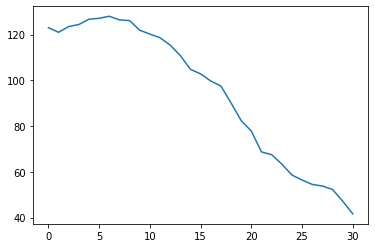

In [10]:
import matplotlib.pyplot as plt

plt.plot(O[-1, :])

Prepare intervention matrix $Z$ that indicates whether the intervention is implemented or not

In [25]:
Z = np.zeros_like(O) # Z has the same shape as O
Z[-1, 19:] = 1 #Only California (the last row) used the intervention, which started in 1989

## Estimators

Now after we have the outcome data ($O \in R^{n\times T}$) and the intervention data ($Z \in R^{n\times T}$), let's show a few methods that can be used directly to assess the impact of the intervention. 

## DID estimation

The first method is difference-in-difference (DID). We use a two-way fixed effects regression to estimate the average treatment effect on the treated entries (ATT). In particular, we solve the following regression by linear regression
$$
\min \sum_{ij} (O_{ij} - a_i - b_j - \tau Z_{ij})^2
$$
where $a_{i}, b_{j}$ are unknown fixed effects and $\tau$ is the ATT. 

To use DID, simply call
```
M, tau = DID(O, Z)
````
with two return parameters `M` and `tau`. Here $M_{ij}=a_{i}+b_{j}$ is the estimated ideal outcomes; and `tau` is the estimated ATT. 

In [28]:
from causaltensor.cauest import DID 

M, tau = DID(O, Z)  
print('The estimation of DID is', tau)

The estimation of DID is -27.335107556961784


## Debiased Convex Panel Regression

The second method is De-biaeed Convex Panel Regression (DC-PR) proposed by [2]. 
Note that an issue of the DID model is that, $a_i+b_j$ are often too simple to describe the complex reality of the outcome. As a fix, a low-rank factor model to generalize $a_i+b_j$ has been advocated. 

The idea in [2] is to firstly solve the following low-rank regression problem by replacing $a_i+b_j$ in DID by a low-rank matrix $M$
$$
\hat{M}, \hat{\tau} = \arg\min \sum_{ij} (O_{ij}-M_{ij}-\tau Z_{ij})^2 + \lambda \|M\|_{*}
$$
where $\|M\|_{*}$ is the nuclear norm to penalize the low-rankness of the matrix and $\lambda$ is a tunning parameter. The second step of [2] is to mitigate the bias induced by the regularization parameter (it also reflects the interaction between $\hat{M}$ and $Z$):
$$
\tau^{d} = \hat{\tau} - \lambda \frac{<Z, \hat{U}\hat{V}^{\top}>}{\|P_{\hat{T}^{\perp}}(Z)\|_{F}^2}.
$$
See [2] for more details. 

To use DC-PR, call
```
M, tau, M_raw, tau_raw = DC_PR_auto_rank(O, Z)
```
where `M`, `tau` are the de-biased versions and `M_raw` and `tau_raw` are the optimizers for the first step. This function helps to find the proper rank for $M$ (but not very stable, and may be updated later). You can also use
```
M, tau, M_raw, tau_raw = DC_PR_with_suggested_rank(O, Z, suggest_r = r)
```
if you have an estimation of the rank of $M$ by yourself. 

In addition, we also provide a formula to estimate the empirical variance of DC-PR when noises are (heterogenoues) independent sub-Gaussian. See [2] for further details. 
```
variance = std_debiased_convex(O, Z, M_raw, tau_raw)
```


[2] Farias, Vivek, Andrew Li, and Tianyi Peng. "Learning treatment effects in panels with general intervention patterns." Advances in Neural Information Processing Systems 34 (2021): 14001-14013.

In [36]:
from causaltensor.cauest import DC_PR_with_suggested_rank
from causaltensor.cauest import std_debiased_convex
from causaltensor.cauest import DC_PR_auto_rank

#M, tau, M_raw, tau_raw = DC_PR_with_suggested_rank(O, Z, suggest_r = 2)
M, tau, M_raw, tau_raw = DC_PR_auto_rank(O, Z)
variance = std_debiased_convex(O, Z, M_raw, tau_raw)
print(tau, variance)

-16.010577370659338 3.9734325031426905


## SDID estimation

The second method is called synthetic difference-in-difference (SDID) proposed by [3]. Readers can read [3] for more details. To use SDID, simply call
```
tau = SDID(O, Z)
```
where `tau` is the estimation of SDID. 

[3] Arkhangelsky, Dmitry, Susan Athey, David A. Hirshberg, Guido W. Imbens, and Stefan Wager. "Synthetic difference-in-differences." American Economic Review 111, no. 12 (2021): 4088-4118.

In [35]:
from causaltensor.cauest import SDID

## to use SDID, cvxopt package is needed

tau = SDID(O, Z)
print('The estimation of SDID is', tau) ## The result matched the result in [2] 

The estimation of SDID is -15.602326126984645


## Matrix Completion

The third method is based on matrix completion method proposed by [4]. The idea is to solve the following matrix completion problem, only using the outcome data without intervention (i.e., $Z_{ij}=0$)
$$
\hat{M}, \hat{a}, \hat{b} = \arg\min \sum_{ij, Z_{ij}=0} (O_{ij}-M_{ij} - a_i - b_j)^2 + \lambda \|M\|_{*}
$$
where $\|M\|_{*}$ is the nuclear norm that penalizes the low-rankness of the matrix (here $a_{i}$ and $b_{j}$ are used to improve the empirical performance, as suggested by [4]). 

After $\hat{M}, \hat{a}, \hat{b}$ are obtained, the ATT $\hat{\tau}$ can be estimated simply by 
$$
\hat{\tau} = \frac{\sum_{ij, Z_{ij}=1} (O_{ij} - \hat{M}_{ij} - \hat{a}_i - \hat{b}_{j})}{\sum_{ij, Z_{ij}=1} 1}.
$$

To use this method (referred to as matrix completion with nuclear norm minimization, or MC-NNM), when you have an estimation of the rank of the matrix $M$ (e.g., by checking the spectrum), call
```
M, a, b, tau = MC_NNM_with_suggested_rank(O, 1-Z, suggest_r = r)
```
where `M`, `a`, `b` are the optimizers and `tau` is the estimated ATT. 

We also provide a function to help you find the right parameter $\lambda$ or rank by cross-validation:
```
M, a, b, tau = MC_NNM_with_cross_validation(O, 1-Z)
```


[4] Athey, Susan, Mohsen Bayati, Nikolay Doudchenko, Guido Imbens, and Khashayar Khosravi. "Matrix completion methods for causal panel data models." Journal of the American Statistical Association 116, no. 536 (2021): 1716-1730.

In [31]:
from causaltensor.cauest import MC_NNM_with_suggested_rank

M, a, b, tau = MC_NNM_with_suggested_rank(O, 1-Z, suggest_r = 1)
tau

-27.017712092108116

In [32]:
from causaltensor.cauest import MC_NNM_with_cross_validation

M, a, b, tau = MC_NNM_with_cross_validation(O, 1-Z)
tau

-19.936496012118962